## Computer vision workshop

Welcome to this Jupyter Notebook on Computer Vision and Convolutional Neural Networks. In a couple of steps we explain how computer vision techniques can be used to manipulate and analyse images and how convolutional neural networks use manipulations to analyse visual material.

## Instructions
Prior knowledge of Python (a computer language) is not needed, but will help you understand this notebook better. The same goes for Jupyter Notebooks. One important thing to understand: a Jupyter notebook consists of cell that can  contain blocks of code, text ('markdown'), or text and code. For example, this block contains markdown only. In cells that contain both text and code, markdown is preceded by a '#' sign. This text is used to explain the function of the code in the same cell. Sometimes we ask a question after an '#' sign. If you want to write your answer down in the same cell, use an # to signify it as markdown. 

In order to make the code work you need to run code in the cells in a top to bottom order. You do this by pressing 'shift + enter', which will automatically take you to the next cell. Try it now!

NB: This notebook was partly based on earlier notebooks/work by <br>
<a href="https://github.com/SeguinBe/DHWorkshop2017" /> Benoit Séguin </a> <br>
<a href="https://distantviewing.org/tutorial-dl" /> Taylor Arnold & Lauren Tilton </a>


In [1]:
# We start by loading several libararies we need to perform the tasks in this notebook. 
# Dont forget to press 'Shift +enter' 
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
from os.path import join

import skimage
from skimage import data, io

## Images and Python

We start by loading an image in the notebook using Python: in this case the image with the filename 'color_train.jpg' from the folder 'images' (see the code below). 'plt.imshow(img)' shows the image in the notebook in a grid, which shows the number of pixels. 

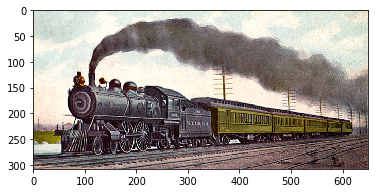

In [2]:
#Load an image using python. 
img = io.imread(join("images", "color_train.jpg"))
plt.imshow(img)

## Pixels
Computers do not see images, but only a large number of pixel values. Each pixel has a value between 0 and 255. As a result, computers are ('only') able to analyse patterns in pixels values. 
<br><br><br><img src="https://openframeworks.cc/ofBook/images/image_processing_computer_vision/images/lincoln_pixel_values.png" /><p style="text-align:center;">
Pixel data diagram. At left, our image of Lincoln; at center, the pixels labeled with numbers from 0-255, representing their brightness; and at right, these numbers by themselves.
</p>
<p style="text-align:center;">
(borrowed from Golan Levin [Image Processing and Computer Vision](https://openframeworks.cc/ofBook/chapters/image_processing_computer_vision.html))</p>

In [3]:
# We can use 'img.shape' to print information on the number of pixels.
# QUESTION: What do the numbers stand for? Look at the image, and the grid pattern, in the image in cell 6. 
# QUESTION: What does the 3 mean? 
img.shape

(308, 650, 3)

## Transformations

Because computers see images as collections of numbers, we can use math to transform the pixel values and, as a result, manipulate the image. 

In [4]:
# Imports the necesarry library
from skimage import transform

(154, 325, 3)

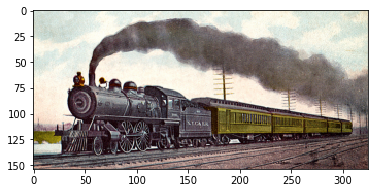

In [5]:
# First we will rescale the image by a factor 0.5 (divide the number of pixels on the X and Y axel by 2)
# QUESTION: The size of the image did not change. Why? What did change? 
rescaled_img = transform.rescale(img, scale=0.5, mode='constant', multichannel=True, anti_aliasing=True)
plt.imshow(rescaled_img)
rescaled_img.shape

(200, 200, 3)

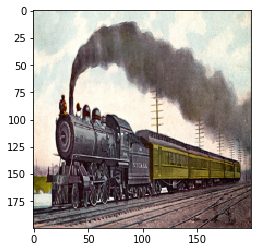

In [6]:
# Now we will resize the image to have a square size of 200 x 200 pixels. 
# Before applying Convolutional Neural Networks, images are often 'preprocessed' in this, and other, ways.
# QUESTION: resizing the image in this way fundamentelly changes our perception of the image. Is this the same for a computer?
resized_img = transform.resize(img, (200,200), mode='constant', anti_aliasing=True)
plt.imshow(resized_img)
resized_img.shape

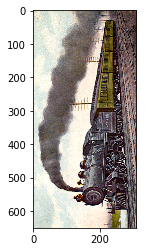

In [7]:
# We can also manipulate the pixels to rotate image by 90° counter-clockwise.
# QUESTION. Which number in the code o you have to change to rotate the picture by a different angle?
rotated_img = transform.rotate(img, 90, resize=True)
plt.imshow(rotated_img)

## Convolutions

Convolutions are another way to manipulate the pixel values of images. You can imagine the mathemetical operation of a convolution as a small screen (known as a kernel) running over the image. The kernel changes the value of the pixel in the middle based on the values of the pixels surrounding it. As we will see below, convolutions highlight certain features of an image. Convolutional Neural Networks use convolutions to extraxt features (complicated patterns in pixel values). Below we apply several convolutions in order to see which features they highlight. 
<br><br><br><img src="https://community.arm.com/cfs-file/__key/communityserver-blogs-components-weblogfiles/00-00-00-20-66/4786.conv.png" /><p style="text-align:center;">
An example of a convolution filter.  Each transformed pixel value is created by multiplying its current value and the values of the pixels around it against a matrix of coefficients
</p>
<p style="text-align:center;">
(borrowed from [Embarrassingly Parallel](https://community.arm.com/graphics/b/blog/posts/when-parallelism-gets-tricky-accelerating-floyd-steinberg-on-the-mali-gpu))</p>

In [8]:
# This cell loads the necessary libraries
from scipy.ndimage.filters import convolve
from scipy import ndimage as ndi
from scipy.signal import convolve2d
from scipy import misc
from skimage import filters

### Blur (Guassian Filter)

In [9]:
# WHAT IS THIS?
x = np.zeros((101, 101))
x[50, 50] = 1
y = ndi.filters.gaussian_filter(x, sigma=16)

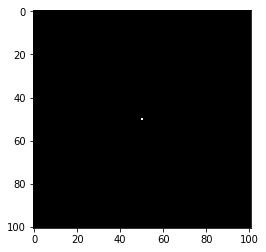

In [10]:
# WHAT IS THIS?
plt.imshow(x, interpolation='none', cmap='gray')

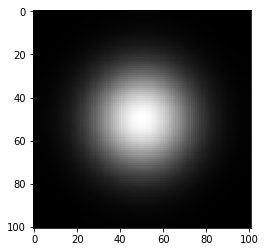

In [11]:
# WHAT IS THIS?
plt.imshow(y, interpolation='none', cmap='gray')

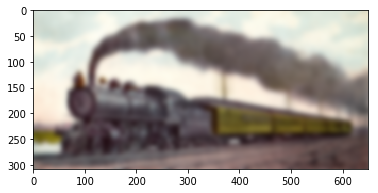

In [12]:
# The code in this cell applies a Guassian Filter to our image of our train.
# QUESTION: Which features are highlighted by a Guassian Filter? 
blurred_image = filters.gaussian(img, 5, multichannel=True)
plt.imshow(blurred_image)

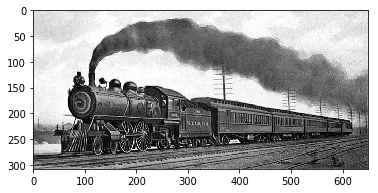

In [13]:
# The code in this cell turns a color image to grayscale image.
grayscale_image = io.imread(join("images", "color_train.jpg"), as_gray=True)
plt.imshow(grayscale_image, cmap='gray')

### The next convolution (Sobel Operator) highlights edges in the image

In [14]:
# WHAT IS THIS?
h_kernel = np.array([[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]])

v_kernel = np.array([[ -1,  0,  1],
                     [ -2,  0,  2],
                     [-1, 0, 1]])



# a1 = np.matrix([1, 2, 1])
# a2 = np.matrix([-1, 0, 1])
# h_kernel = a1.T * a2
# v_kernel = a2.T * a1

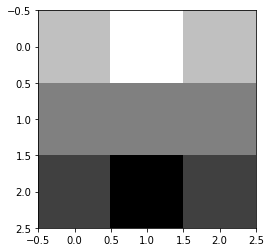

In [15]:
# WHAT IS THIS?
plt.imshow(h_kernel, cmap='gray')

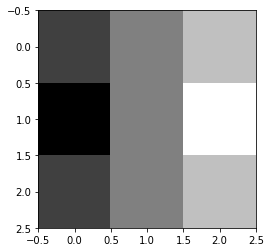

In [16]:
# WHAT IS THIS?
plt.imshow(v_kernel, cmap='gray')

In [17]:
# Apply the Sobel operator
Gx = convolve2d(grayscale_image, h_kernel)
Gy = convolve2d(grayscale_image, v_kernel)
G = np.sqrt(Gx**2 + Gy**2)

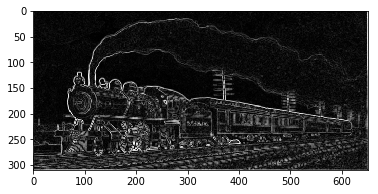

In [18]:
# WHAT IS THIS?
plt.imshow(G, cmap='gray')

In [19]:
# WHAT IS THIS?
sobel_h = filters.sobel_h(grayscale_image)
sobel_v = filters.sobel_v(grayscale_image)
sobel = filters.sobel(grayscale_image)

(-0.5, 649.5, 307.5, -0.5)

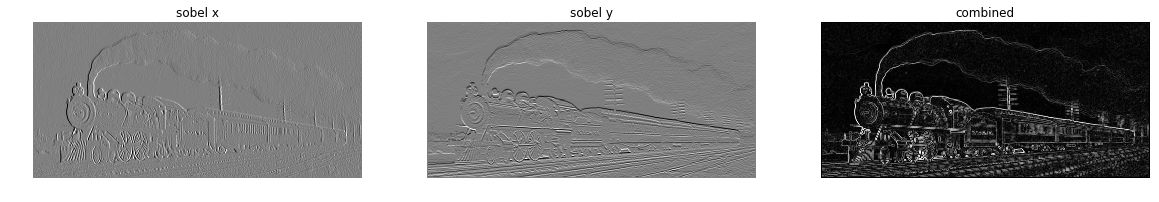

In [20]:
# # WHAT IS THIS?
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title('sobel x')
plt.imshow(sobel_v, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('sobel y')
plt.imshow(sobel_h, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('combined')
plt.imshow(sobel, cmap='gray')
plt.axis('off')

## Building your own Convolutional Neural Network

Convolution Neural Networks are able to detect patterns in pixel values that signify visual similarity to us. They do this by learning (Artificial Intelligence) significant simalarities and differences in a collection of images. As we will see below, convolutions play an important role in the architecture, the specific sequence of different layers, of a convolutional neural network. 

We will start by building our own classifier. On of the first convolutional neural networks was used to recognize handwritten digitis. The network was trained on data from the MNIST dataset, which contains 60,000 training and 10,000 testing images. We use Keras, a open-source neural network library written in Python, to start building our own convolutional neural netwerk.

If you feel you do not understand how convolutional neural networks work consider watching <a href="https://www.youtube.com/watch?v=CsN-qwpF8Bc" /> this short (somewhat embrassing) movie </a> I (Thomas) made for the Universiteit van Nederland (Dutch). 

In [21]:
# Loads the MNIST dataset
from keras.datasets import mnist

Using TensorFlow backend.


In [23]:
# Loads the training and testing images.
# If you could an error. Try going to the Python 3 folder on your computer and run the Install Certificates.comand
# QUESTION What is the difference between X_train and Y_train? 
(X_train, y_train), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

In [24]:
# Shows the shape (structure) of the X_train and X_Test set .
X_train.shape
X_test.shape

(10000, 28, 28)

In [25]:
# Shows the first entry in the X_train dataset
# QUESTION: Which number do you have to fill in if you would want to print the 10th entry? Why?
X_train[0] 

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

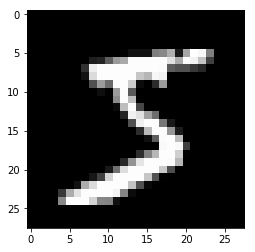

In [26]:
# Shows the images of the first entry in the X_train set. 
plt.imshow(X_train[0], cmap='gray')

In [27]:
# Reshapes the images of the X_train set to 28X28 pixels. 
# QUESTION: Think of kernel going over the image (especially its edges). Why do we reshape the image into squares?
# WHAT DOES THE -1 mean? 
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

In [28]:
# Shows the new shape of the X_train set.
X_train.shape

(60000, 784)

In [29]:
# Shows the first entry in the X_train set. 
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [30]:
# Transform the numbers of the dataset from integers (numbers recognized as numbers by Python) to floats (numbers recognized as written text). 
# WHY DO WE DO THIS?
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [31]:
# Imports a specific function of the Keras library
from keras.utils.np_utils import to_categorical

In [32]:
# WHY?
y_train[0]

5

In [33]:
# Dont get this.
# go to 10 binary columns
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [34]:
y_train_cat.shape

(60000, 10)

In [35]:
y_test_cat.shape

(10000, 10)

In [36]:
y_train[0]

5

In [37]:
y_train_cat[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [38]:
# Imports several functions from the Keras library.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MaxPool2D, AvgPool2D, Conv2D
from keras.layers import Flatten, Activation
import keras.backend as K

In [39]:
# WHAT DOES THIS DO?
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [40]:
# This cell describes the architecture of our network. It consists of different kinds of layers. 
# We already know the convolutional layer: our models has 32 filters in one layer.
# (Max)Pooling layers reduce the complextity of the information of the image. By doing this, the network only 'remembers' the relevant infomation of the previous convolutional layers
# Flatten: WHAT DOES THIS DO?

K.clear_session()

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1))) #convolution layer 32 filters (3 x 3 pixels), output 26x26
model.add(MaxPool2D(pool_size=(2, 2))) # pooling layer to reduce size output is 13x13 
model.add(Activation('relu')) 

model.add(Flatten()) #flatten tensor into long array

model.add(Dense(128, activation='relu')) 

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
# This cell describes the architecture of our network (model)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [42]:
h = model.fit(X_train, y_train_cat, batch_size=128,
          epochs=3, verbose=1, validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/3
42000/42000 [==============================] - 35s 835us/step - loss: 0.2708 - acc: 0.9193 - val_loss: 0.1341 - val_acc: 0.9596
Epoch 2/3
42000/42000 [==============================] - 34s 803us/step - loss: 0.0817 - acc: 0.9752 - val_loss: 0.0913 - val_acc: 0.9723
Epoch 3/3
42000/42000 [==============================] - 33s 788us/step - loss: 0.0525 - acc: 0.9848 - val_loss: 0.0671 - val_acc: 0.9808


In [43]:
# in 2 epochs already performing better than fully-connected model

In [44]:
model.evaluate(X_test, y_test_cat)

10000/10000 [==============================] - 4s 370us/step


[0.055529081837413834, 0.9824]

10000/10000 [==============================] - 4s 358us/step


0.9824

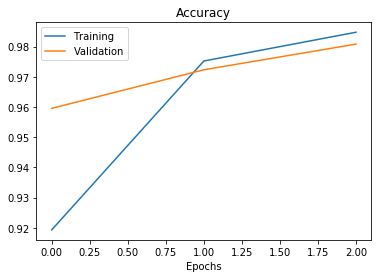

In [45]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

test_accuracy = model.evaluate(X_test, y_test_cat)[1]
test_accuracy

## Image classification

Convolutional neural networks are often used for image and/or object classification. The task of networks is to flag an image in a set if it contains a specific object, scene, colour scheme etc etc (image classification) or detect and 'box' a specific number of predetermined object categories (see image below)
<br><br><br><img src="https://www.pyimagesearch.com/wp-content/uploads/2017/09/example03_result.jpg" /><p style="text-align:center;"> A person riding a horse and two potted plants are successfully identified despite a lot of objects in the image via deep learning-based object detectio
</p>
<p style="text-align:center;">
(borrowed from [Object detection with deep learning](https://www.pyimagesearch.com/2017/09/11/object-detection-with-deep-learning-and-opencv/))</p>


In [46]:
# Loads functions from Keras library
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model

## Using VGG19 for image classification

The VGG19 model was trained to identify 1000 classes of objects within an image. It was built as part of the ImageNet challenge, one of the most influential computer vision competitions that has been running since 2010.


<img src="https://lihan.me/assets/images/vgg-hero-cover.jpg"/>

<p style="text-align:center;">
__VGG19 Architecture__
</p>
<p style="text-align:center;">
(borrowed from [vgg19-caltech101-classification](https://lihan.me/2018/01/vgg19-caltech101-classification/))
</p>

VGG models described in the [original paper](https://arxiv.org/pdf/1409.1556.pdf) are trained with images whose size is 224x224x3. This can not be changed, so the input image for the transfer learning task should have the same image size.

In [47]:
# WHAT DOES THIS DO?
vgg19_full = VGG19(weights='imagenet')
vgg19_full.summary()

574717952/574710816 [==============================] - 103s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_

In [48]:
# Loads an image of a 'bloemkool' from the folder 'images'
# QUESTION: Can you load your own image?
img_path = join("images", "bloemkool.jpg")
img = image.load_img(img_path, target_size=(224, 224)) #image needs to be 224 x 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [49]:
x.shape

(1, 224, 224, 3)

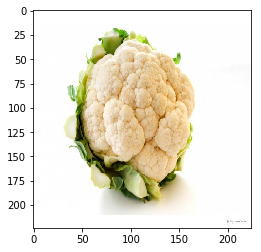

In [50]:
plt.imshow(img)

In [51]:
# This cell uses VGG19 to predict what the image shows.
# QUESTION: Can you predict the category of a random image from the internet using this notebook?
prediction = vgg19_full.predict(x)
print(prediction.shape)
for pred in decode_predictions(prediction)[0]:
        print(pred)


(1, 1000)
40960/35363 [==================================] - 0s 2us/step
('n07715103', 'cauliflower', 0.99937123)
('n07760859', 'custard_apple', 0.00032514727)
('n07714990', 'broccoli', 0.00026529346)
('n07714571', 'head_cabbage', 2.6980717e-05)
('n07718747', 'artichoke', 3.2956782e-06)


## Train your own classifier

In [52]:
## ADD MORE IMAGES AND SMALLER IMAGES SPEEDS UP

In [53]:
from keras.applications import inception_v3

In [54]:
# Instantiate the architecture, with pre-trained parameters from ImageNet
# but without the final (top) layer of object classification
# and averaging (avg) the output feature maps to get a constant size feature vector
# Inception is faster than VGG19 in training
model = inception_v3.InceptionV3(include_top=False, pooling='avg', weights='imagenet')
#model = VGG19(include_top=False, pooling='avg', weights='imagenet')

87916544/87910968 [==============================] - 23s 0us/step


In [55]:
## Building classifier

In [57]:
#model = inception_v3.InceptionV3(include_top=False, pooling='avg', weights='imagenet')

def extract_features(img):
    x = np.expand_dims(img.astype(np.float32), axis=0)  # Make a batch of 1 image by expanding the first dimension
    x = inception_v3.preprocess_input(x)  # Preprocess the input image ([0,255] range to [-1,+1])
    return model.predict(x)[0]  # Make the batch goes through the network and convert the batch back to single image

In [58]:
from glob import glob
from tqdm import tqdm

# Gather the image files in each directory
filenames_bakfiets = glob('data/bakfiets/*.jpg')
print("Number of training positive files : {}".format(len(filenames_bakfiets)))
filenames_random = glob('data/random/*.jpg')
print("Number of training negative files : {}".format(len(filenames_random)))
filenames_test = glob('data/test/*.jpg')
print("Number of test files : {}".format(len(filenames_test)))

Number of training positive files : 24
Number of training negative files : 12
Number of test files : 7


In [60]:
features = []
labels = []
# Extracting features for the positive images
for filename in tqdm(filenames_bakfiets, desc='Computing features for bakfiets images'):
    img = io.imread(filename)
    # Add the CNN features to the list
    features.append(extract_features(img))
    # Add the positive label to the list
    labels.append(1.)
# Extracting features for the negative images
for filename in tqdm(filenames_random, desc='Computing features for random images'):
    img = io.imread(filename)
    # Add the CNN features to the list
    features.append(extract_features(img))
    # Add the negative label to the list
    labels.append(0.)
features = np.stack(features)
labels = np.array(labels)

Computing features for random images: 100%|██████████| 12/12 [02:07<00:00, 10.64s/it]


In [61]:
print(features.shape)
print(features)

(36, 2048)
[[0.13411948 0.30233747 0.15756145 ... 0.16271488 0.24304846 0.34224725]
 [0.09755987 0.13348146 0.1025316  ... 0.20512898 0.14899969 0.25058568]
 [0.15465088 0.06735083 0.16744918 ... 0.11803865 0.14359917 0.21842442]
 ...
 [0.20696186 0.1714827  0.06869043 ... 0.05591653 0.18016326 0.31207532]
 [0.4222468  0.10495638 0.26702428 ... 0.5144506  0.7541906  0.38205412]
 [0.36056176 0.36211303 0.07993904 ... 0.47336817 0.25411373 0.33545062]]


In [62]:
print(labels)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [63]:
from sklearn.svm import SVC

# Instantiate a classifier that will predict a probability
classifier = SVC(probability=True, kernel='linear')
# Train the binary classifier from the extracted features and telling it which images are the good ones with the labels
classifier.fit(features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Predicting: 100%|██████████| 7/7 [00:28<00:00,  4.14s/it]


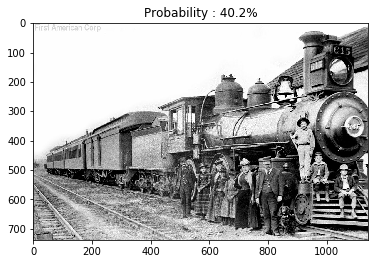

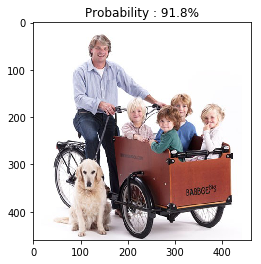

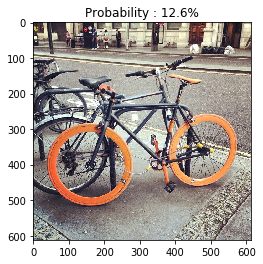

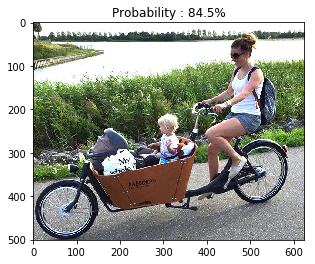

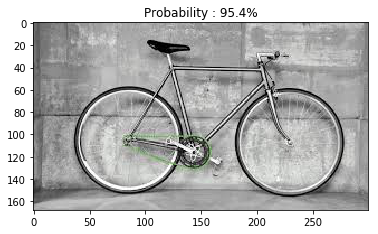

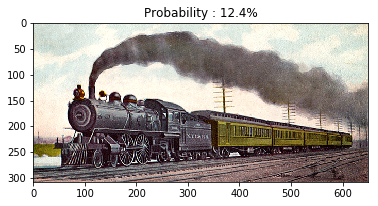

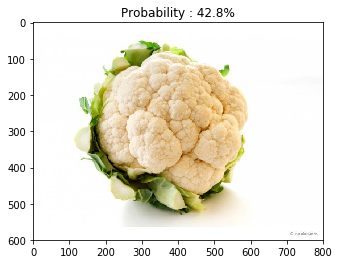

In [64]:
# For each image in the test data
for filename in tqdm(filenames_test, desc="Predicting"):
    # Load the image
    img = io.imread(filename)
    # Extract the features
    feat = extract_features(img)
    # Get the probabilities for the computed features
    probs = classifier.predict_proba(np.expand_dims(feat, axis=0))[0]
    prob_bakfiets = probs[1]  # probs[0] would be the probability of negative class, probs[1] is for the positive class
    # Display the results
    plt.figure()
    plt.imshow(img)
    plt.title("Probability : {:.01f}%".format(100*prob_bakfiets))

## Face detection

An important task of computer vision is face detecting. In the past, face detection was achieved by recognizing the relative distance between 'facial markers'. In recent years, machine learning has also greatly improved the task of face detection.<br><br><br><img src="https://i.dailymail.co.uk/i/pix/2015/02/18/25CCD2F400000578-2958597-image-a-27_1424270103152.jpg" /><p style="text-align:center;">
__Face Detection__
</p>
<p style="text-align:center;">
(Stolen from [A British tabloid](https://pleasedonotreportus.com/))
</p>

In [65]:
# Imports the face_recognition library
import face_recognition as fr

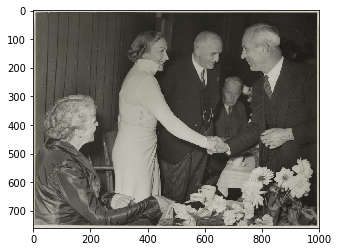

In [66]:
# Load the image face.jpg from the folder faces.
img_path = join('images', 'faces', 'face.jpg')
img = fr.load_image_file(img_path)
plt.imshow(img)

In [ ]:
# ??????
face_locations = fr.face_locations(img, number_of_times_to_upsample=2, model='cnn')

In [ ]:
# ???????
face_locations

In [ ]:
fig,ax = plt.subplots(1,1)
plt.imshow(img)
n, m, d = img.shape
for face in face_locations:
    rect = plt.Rectangle((face[3], face[0]), face[2] - face[0], face[1] - face[3],
                         edgecolor='orange', linewidth=2, facecolor='none')
    ax.add_patch(rect)

## Thank you! 

If you have any questions please email us or visit our websites.

<a href="https://melvinwevers.github.io/" />Melvin Wevers </a> - EMAIL <br>
<a href="http://illustratednewspictures.tumblr.com/" /> Thomas Smits </a> - thomassmits@hotmail.com